In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/trungit/wikiart25k'
od.download(dataset_url, force=True)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: avitakku
Your Kaggle Key: ··········


100%|██████████| 7.74G/7.74G [00:31<00:00, 267MB/s]


In [ ]:
!pip install optim

  Preparing metadata (setup.py) ... done
  Created wheel for optim: filename=optim-0.1.0-py2.py3-none-any.whl size=2705 sha256=dcf512a3684d4e9b49500a039ced60ccdd5bd32c4b9cfc6eca35a8eb6712902c
  Stored in directory: /root/.cache/pip/wheels/63/cd/16/e7762fdd7862a4f618fa7ca62119fac2112de90041cee77227
Successfully built optim


In [1]:
import pandas as pd
import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from torchvision.models import resnet50
from torchtext.data.metrics import bleu_score
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from transformers import AutoTokenizer, BertModel, BertConfig, BertTokenizer
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split


## Cleaning the dataset

When we downloaded the dataset off of Kaggle, a lot of the filenames downloaded with non ascii characters. I was unable to clean these effectively, so I decided to delete the files entirely as the dataset was big enough.

In [ ]:
import os

# function to delete incorrectly encoded files

def delete_non_ascii_filenames(directory):
    count = 0
    for subdir, _, files in os.walk(directory):
        for file in files:
            try:
                file.encode('ascii')
            except UnicodeEncodeError:  # Filename is non-ASCII
                full_path = os.path.join(subdir, file)
                os.remove(full_path)  # Delete the file
                count += 1
                print(f"Deleted file: {full_path}")
    return count

# Use the function on your dataset directory and delete non-ASCII files
deleted_count = delete_non_ascii_filenames('wikiart25k')
print(f"Total deleted files: {deleted_count}")


Total deleted files: 0


Here I am creating a new dataframe that doesn't include the images that I deleted.

In [ ]:
# Load dataset
df = pd.read_csv('drive/MyDrive/Applied_CV/valid_images.csv')

In [ ]:
# initializing new dataframe
trimmed_valid_images_df = pd.DataFrame(columns=df.columns)

In [2]:
def get_image_path(art_style, painting, top_dir='wikiart25k'):
    path = f"{top_dir}/{art_style}/{painting}.jpg"
    return path

In [ ]:
# go through each row in the dataset
valid_rows = []

for index, row in df.iterrows():
    art_style = row['art_style']
    print(art_style)
    painting = row['painting']
    print(painting)
    image_path = get_image_path(art_style, painting)

    # check if the image exists in archive
    # if image found, save the row to list
    try:
        with Image.open(image_path):
            valid_rows.append(row)
    except FileNotFoundError:
        continue

# create a new dataframe with the valid rows
trimmed_valid_images_df = pd.DataFrame(valid_rows, columns=df.columns)

# save the new dataframe to a csv file
trimmed_valid_images_df.to_csv('drive/MyDrive/Applied_CV/trimmed_valid_images.csv', index=False)

Streaming output truncated to the last 5000 lines.
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask-of-the-red-death-1883
Symbolism
odilon-redon_the-mask

In [3]:
model_df = pd.read_csv('drive/MyDrive/Applied_CV/trimmed_valid_images.csv')

In [4]:
def get_image_path(art_style, painting, top_dir='wikiart25k'):
    path = f"{top_dir}/{art_style}/{painting}.jpg"
    return path

In [5]:
print(model_df.iloc[1])

art_style                                         Impressionism
painting                          willard-metcalf_havana-harbor
emotion                                             contentment
utterance     The red of the flowers pop off the page, it is...
repetition                                                    7
Name: 1, dtype: object


## Creating Dataset and Dataloaders

In [ ]:
class CaptionDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = get_image_path(self.df.iloc[idx]['art_style'], self.df.iloc[idx]['painting'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = self.df.iloc[idx]['utterance']

        return {'image': image, 'caption': caption}

In [6]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
def collate_fn(batch):
    images = [item['image'] for item in batch]
    images_stacked = torch.stack(images)

    captions = [item['caption'] for item in batch]
    captions_tokenized = tokenizer(
        captions,
        padding=True,
        return_tensors='pt'
    )

    return {'images': images_stacked, 'captions': captions_tokenized['input_ids']}

In [14]:
# Separate the dataset into training, testing, and validation sets

train_val_df, test_df = train_test_split(model_df, test_size=0.2)

train_df, val_df = train_test_split(train_val_df, test_size=0.25)

###Inspecting the Images

In [ ]:
# Display 3 randomly chosen images using matplotlib.  Consider the colormap so

image1 = Image.open(get_image_path(model_df.iloc[0]['art_style'], model_df.iloc[0]['painting'])).convert('RGB')
image2 = Image.open(get_image_path(model_df.iloc[10]['art_style'], model_df.iloc[10]['painting'])).convert('RGB')
image3 = Image.open(get_image_path(model_df.iloc[200]['art_style'], model_df.iloc[200]['painting'])).convert('RGB')

fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.imshow(image1, cmap='gray')
ax1.set_title('Image 1')
ax2.imshow(image2, cmap='gray')
ax2.set_title('Image 2')
ax3.imshow(image3, cmap='gray')
ax3.set_title('Image 3')

NameError: name 'get_image_path' is not defined

Clearly the images aren't the same size, so I am applying transforms to resize and also normalize.


In [16]:

transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Match the expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])


### Creating the dataset and dataloader

In [ ]:
train_dataset = CaptionDataset(train_df, tokenizer, transform)
val_dataset = CaptionDataset(val_df, tokenizer, transform)
test_dataset = CaptionDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

## Model 1: CNN and LSTM

### Model Class

I am using a CNN to extract features from images (ResNet50) and then using an LSTM to generate captions

In [ ]:
class ImageCaptioningModel(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers):
        super(ImageCaptioningModel, self).__init__()

        # load pretrained resnet model
        resnet = resnet50(pretrained=True)

        # freeze the resnet layers so that they are not trained
        for param in resnet.parameters():
            param.requires_grad = False

        # remove the classification layer and replace it with a linear layer
        # this reduces the output dimension to match the embedding dimension
        resnet.fc = nn.Linear(resnet.fc.in_features, embed_dim)
        self.cnn = resnet

        # LSTM for generating captions
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=0.5 if num_layers > 1 else 0)

        # output layer that maps the hidden state output dimension to the vocab size
        # this helps to predict the next word in the caption
        self.linear = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, images, captions):

        # extract features from images
        image_features = self.cnn(images)

        # unsqueeze the dimensions of the features tensor
        # repeat it so that the same features are used for each word in the caption
        features = image_features.unsqueeze(1).repeat(1, captions.size(1), 1)

        # get output from the LSTM
        # a new hidden state is generated for each word in the caption
        lstm_output, _ = self.lstm(features)

        # linear layer takes output and predicts the next word in the caption
        outputs = self.linear(lstm_output)

        print("Sample outputs:", outputs[0, :5])

        return outputs

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
image_to_caption_model = ImageCaptioningModel(embed_dim=256, hidden_dim=512, vocab_size=len(tokenizer.vocab), num_layers=1)
model =image_to_caption_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Researching Hyperparameters

To determine what a good learning rate would be, I researched a method that would help:

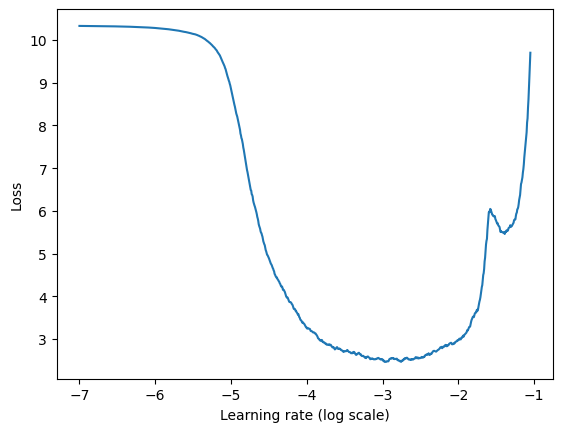

In [ ]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def find_learning_rate(model, train_loader, criterion, init_value=1e-7, final_value=10.0, beta=0.98):
    num = len(train_loader) - 1
    mult = (final_value / init_value) ** (1/num)
    lr = init_value
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    avg_loss = 0.0
    best_loss = float('inf')
    batch_num = 0
    losses = []
    log_lrs = []

    for data in train_loader:
        batch_num += 1
        # Get the inputs and labels
        inputs, labels = data['images'].to(device), data['captions'].to(device)

        # Clear gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs, labels[:, :-1])
        loss = criterion(outputs.view(-1, outputs.size(-1)), labels[:, 1:].contiguous().view(-1))

        # Compute the smoothed loss
        avg_loss = beta * avg_loss + (1-beta) * loss.item()
        smoothed_loss = avg_loss / (1 - beta**batch_num)

        # Stop if the loss is exploding
        if batch_num > 1 and smoothed_loss > 4 * best_loss:
            break

        # Record the best loss
        if smoothed_loss < best_loss:
            best_loss = smoothed_loss

        # Store the values
        losses.append(smoothed_loss)
        log_lrs.append(np.log10(lr))

        # Do backward pass and step the optimizer
        loss.backward()
        optimizer.step()

        # Update the learning rate
        lr *= mult
        optimizer.param_groups[0]['lr'] = lr

    plt.plot(log_lrs, losses)
    plt.xlabel("Learning rate (log scale)")
    plt.ylabel("Loss")
    plt.show()

# Usage
find_learning_rate(model, train_loader, criterion)


This graph shows that a learning rate of around 1e-3 would be the best, as it would have the lowest loss. However, the loss is still kind of high.

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

I tested my code with and without a scheduler as well. I tried both StepLR and ReduceROnPlateau. I didn't see a huge difference between these, but the losses with ReduceROnPlateau were slightly lower.

In [ ]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.1, verbose=True)

### Bleu score

To determine how to calculate the accuracy of an NLP model, I found a metric called a "bleu score". I looked up an implementation of calculating it:

In [ ]:
def calculate_bleu(data_loader, model, device, tokenizer):
    candidate_corpus = []
    reference_corpus = []
    model.eval()
    with torch.no_grad():
        for batch in data_loader:
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            outputs = model(images, captions[:, :-1])
            # Convert model outputs to text
            output_captions = torch.argmax(outputs, dim=-1)
            for i in range(outputs.size(0)):
                # Convert predicted ids to tokens
                candidate_tokens = tokenizer.convert_ids_to_tokens(output_captions[i], skip_special_tokens=True)
                candidate_corpus.append(candidate_tokens)

                # Convert ground truth ids to tokens
                ref_tokens = tokenizer.convert_ids_to_tokens(captions[i, 1:], skip_special_tokens=True)
                reference_corpus.append([ref_tokens])  # Note: the reference corpus is a list of lists of tokens

    # Compute BLEU score
    bleu = bleu_score(candidate_corpus, reference_corpus)
    return bleu


### Train and validation loop

In [ ]:
def validate_model(model, val_loader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            outputs = model(images, captions[:, :-1])
            loss = criterion(outputs.reshape(-1, outputs.shape[2]), captions[:, 1:].reshape(-1))
            total_val_loss += loss.item()

    average_val_loss = total_val_loss / len(val_loader)
    return average_val_loss


In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    for i, batch in enumerate(train_loader):
        images = batch['images'].to(device)
        captions = batch['captions'].to(device)

        # for i, caption_ids in enumerate(captions[:3]):  # Loop through the first few captions in the batch
        #   caption = tokenizer.decode(caption_ids.cpu().tolist(), skip_special_tokens=True)
        #   print(f"Decoded Caption [{i}]: {caption}")

        # excluding the last word in the caption (<end> token)
        outputs = model(images, captions[:, :-1])

        # offset the caption by one to the right (exclude the <start> token)
        loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].contiguous().view(-1))

        optimizer.zero_grad()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        total_loss += loss.item()

        if (i + 1) % 10 == 0:
            print(f"Epoch Batch {i+1}: Loss = {loss.item():.4f}")

        #print_predictions(outputs, tokenizer)

    average_loss = total_loss / len(train_loader)
    return average_loss

### Running with lr = 1e-3 and for 15 epochs

In [ ]:
def train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, epochs, device):
    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")

        # Train one epoch
        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        print(f"Training Loss: {train_loss:.4f}")

        # Validate after training
        val_loss = validate_model(model, val_loader, criterion, device)
        print(f"Validation Loss: {val_loss:.4f}")

        # Calculate BLEU score for the validation set
        bleu = calculate_bleu(val_loader, model, device, tokenizer)
        print(f"Validation BLEU Score: {bleu:.4f}")

        scheduler.step(val_loss)

# Assuming 'model', 'train_loader', 'val_loader', 'optimizer', 'criterion' and 'device' are defined
train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, 15, device)

Epoch 1/15
Epoch Batch 10: Loss = 2.4271
Epoch Batch 20: Loss = 2.3470
Epoch Batch 30: Loss = 1.9763
Epoch Batch 40: Loss = 3.5809
Epoch Batch 50: Loss = 2.0520
Epoch Batch 60: Loss = 2.6291
Epoch Batch 70: Loss = 2.4001
Epoch Batch 80: Loss = 2.6934
Epoch Batch 90: Loss = 1.8244
Epoch Batch 100: Loss = 2.6809
Epoch Batch 110: Loss = 2.6268
Epoch Batch 120: Loss = 2.8100
Epoch Batch 130: Loss = 2.9043
Epoch Batch 140: Loss = 2.6058
Epoch Batch 150: Loss = 2.4262
Epoch Batch 160: Loss = 2.5447
Epoch Batch 170: Loss = 2.1028
Epoch Batch 180: Loss = 1.9502
Epoch Batch 190: Loss = 1.3966
Epoch Batch 200: Loss = 2.5812
Epoch Batch 210: Loss = 1.2794
Epoch Batch 220: Loss = 2.8686
Epoch Batch 230: Loss = 2.3991
Epoch Batch 240: Loss = 2.3958
Epoch Batch 250: Loss = 2.2793
Epoch Batch 260: Loss = 2.8416
Epoch Batch 270: Loss = 2.8380
Epoch Batch 280: Loss = 1.9150
Epoch Batch 290: Loss = 2.4061
Epoch Batch 300: Loss = 2.7443
Epoch Batch 310: Loss = 2.8670
Epoch Batch 320: Loss = 2.6701
Epoch 

In [ ]:
torch.save(model.state_dict(), 'image_to_cap_model.pth')

My bleu score is clearly very low, and my losses are very high. I want to print out example predicted captions to see what this model is doing.

In [ ]:
def print_predictions(outputs, tokenizer):
    probabilities = torch.nn.functional.softmax(outputs, dim=-1)
    predicted_indices = torch.argmax(probabilities, dim=-1)

    for i in range(min(3, predicted_indices.size(0))):  # Ensures no out-of-bounds error
        predicted_tokens = predicted_indices[i].cpu().tolist()
        caption = tokenizer.decode(predicted_tokens, skip_special_tokens=True)
        print(f"Predicted Caption [{i}]: {caption}")

        # Iterate over each time step in the sequence to print top predictions
        for t in range(predicted_indices.size(1)):
            top_probs, top_indices = torch.topk(probabilities[i, t], 5)
            print(f"Time step {t}:")
            for prob, idx in zip(top_probs, top_indices):
                token = tokenizer.convert_ids_to_tokens(idx.item())
                print(f"  Token: {token}, Probability: {prob.item()}")

In [ ]:
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    for i, batch in enumerate(train_loader):
        images = batch['images'].to(device)
        captions = batch['captions'].to(device)

        for i, caption_ids in enumerate(captions[:3]):  # Loop through the first few captions in the batch
          caption = tokenizer.decode(caption_ids.cpu().tolist(), skip_special_tokens=True)
          print(f"Decoded Caption [{i}]: {caption}")

          # excluding the last word in the caption (<end> token)
          outputs = model(images, captions[:, :-1])

          # offset the caption by one to the right (exclude the <start> token)
          loss = criterion(outputs.view(-1, outputs.size(-1)), captions[:, 1:].contiguous().view(-1))

          optimizer.zero_grad()

          loss.backward()
          torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
          optimizer.step()

          total_loss += loss.item()

          if (i + 1) % 10 == 0:
              print(f"Epoch Batch {i+1}: Loss = {loss.item():.4f}")

          print_predictions(outputs, tokenizer)

    average_loss = total_loss / len(train_loader)
    return average_loss


In [ ]:
train_and_evaluate(model, train_loader, val_loader, optimizer, criterion, 10, device)


Epoch 1/10
Decoded Caption [0]: blech, i don't like the dizzying geometric design and overall i don't understand it and it makes me dizzy
Sample outputs: tensor([[-0.0118, -0.0081,  0.0201,  ..., -0.0408,  0.0143,  0.0431],
        [-0.0157, -0.0216,  0.0095,  ..., -0.0490,  0.0231,  0.0488],
        [-0.0161, -0.0247,  0.0020,  ..., -0.0526,  0.0267,  0.0541],
        [-0.0158, -0.0244, -0.0030,  ..., -0.0540,  0.0278,  0.0584],
        [-0.0154, -0.0233, -0.0062,  ..., -0.0544,  0.0279,  0.0615]],
       device='cuda:0', grad_fn=<SliceBackward0>)
Predicted Caption [0]: bride bride bride bride bride bridewormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormworm
Time step 0:
  Token: bride, Probability: 3.659578942460939e-05
  Token: fleetwood, Probability: 3.64493862434756e-05
  Token: ##holders, Probability: 3.637522240751423e-05
  Token: ##nb, Probability: 3.630347055150196e-05
  Token: 1718, Probability: 3.625045792

KeyboardInterrupt: 

Clearly, most of the captions were gibberish.

e.g. Predicted Caption [0]: bride bride bride bride bride bridewormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormwormworm

or

Predicted Caption [1]: services debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts debts

## Model 2: CNN and Transformer

### Creating new dataset

I decided to try and use a different method of generating captions. This would require a slightly different set up for my Dataset.

In [ ]:
class CaptionDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None, max_length=32):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = get_image_path(self.df.iloc[idx]['art_style'], self.df.iloc[idx]['painting'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = self.df.iloc[idx]['utterance']
        inputs = self.tokenizer.encode_plus(
            caption,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors="pt"
        )

        # Shift the captions to the right to create targets
        input_ids = inputs['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)
        targets = input_ids.clone()
        targets[:-1] = input_ids[1:]  # Shift input ids to the left
        targets[-1] = self.tokenizer.pad_token_id  # Pad token at the end

        return {
            'image': image,
            'ids': input_ids,
            'mask': attention_mask,
            'targets': targets
        }

def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    ids = torch.stack([item['ids'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    targets = torch.stack([item['targets'] for item in batch])

    return {
        'images': images,
        'ids': ids,
        'masks': masks,
        'targets': targets
    }

In [ ]:
train_val_df, test_df = train_test_split(model_df, test_size=0.2)

train_df, val_df = train_test_split(train_val_df, test_size=0.25)

In [ ]:
train_dataset = CaptionDataset(train_df, tokenizer, transform)
val_dataset = CaptionDataset(val_df, tokenizer, transform)
test_dataset = CaptionDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

### Generate Model Class

I decided to create a model that uses a transformer and a generate method.

In [ ]:
def softmax_with_temperature(logits, temperature=0.5):
    return torch.softmax(logits / temperature, dim=-1)

In [ ]:
class ImageCaptioningModel_Generate(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers, transformer_model="bert-base-uncased"):

        super(ImageCaptioningModel_Generate, self).__init__()

        # Load pretrained ResNet model
        self.resnet = resnet50(pretrained=True)

        # Freeze the ResNet layers
        for param in self.resnet.parameters():
            param.requires_grad = False

        # Replace the classification layer
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_dim)

        # BERT configuration
        config = BertConfig.from_pretrained(transformer_model, hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5)
        config.bos_token_id = 101  # [CLS] token for BERT
        config.eos_token_id = 102  # [SEP] token for BERT
        self.transformer = BertModel(config)

        # Transform embedding dimension to transformer's hidden size
        self.embedding_transform = nn.Linear(embed_dim, self.transformer.config.hidden_size)
        self.batch_norm = nn.BatchNorm1d(self.transformer.config.hidden_size)

        # Output layer
        self.fc = nn.Linear(self.transformer.config.hidden_size, vocab_size)

    def forward(self, images, input_ids=None, attention_mask=None):
        image_features = self.resnet(images)
        #print("Shape after ResNet:", image_features.shape)  # Expect [64, 256]
        image_features = self.embedding_transform(image_features)
        #print("Shape after Embedding Transform:", image_features.shape)  # Expect [64, 768]
        image_features = self.batch_norm(image_features)
        #print("Shape after BatchNorm:", image_features.shape)  # Expect [64, 768]

        if input_ids is None:
            #print("Shape before calling generate:", image_features.shape)  # Last check before generate
            return self.generate(image_features, max_length=50)
        else:
            image_features = image_features.unsqueeze(1).repeat(1, input_ids.size(1), 1)
            #print("Shape after Unsqueeze and Repeat:", image_features.shape)  # Expect [64, <seq_len>, 768]
            transformer_out = self.transformer(inputs_embeds=image_features, attention_mask=attention_mask)[0]
            outputs = self.fc(transformer_out)
            return outputs

    def generate(self, image_features, max_length=50):
        #print("Received Image Features Shape in Generate:", image_features.shape)  # Immediate check on entry
        input_ids = torch.full((image_features.size(0), 1), self.transformer.config.bos_token_id,
                              device=image_features.device, dtype=torch.long)

        for _ in range(max_length - 1):
            current_seq_length = input_ids.size(1)
            image_features_expanded = image_features.unsqueeze(1).expand(-1, current_seq_length, -1)
            attention_mask = torch.ones((input_ids.size(0), current_seq_length), device=image_features.device, dtype=torch.long)

            transformer_out = self.transformer(inputs_embeds=image_features_expanded, attention_mask=attention_mask)[0]
            next_word_logits = self.fc(transformer_out[:, -1, :])
            next_word_probs = softmax_with_temperature(next_word_logits)
            next_word = torch.multinomial(next_word_probs, 1)
            input_ids = torch.cat([input_ids, next_word], dim=1)

            if torch.all(next_word == self.transformer.config.eos_token_id):
                break

        return input_ids

### Beam Search Model Class

I also decided to experiment with a model that used beam search the determine each word in the caption instead of a generate function.

In [ ]:
import torch.nn.functional as F

In [ ]:
def softmax_with_temperature(logits, temperature=0.5):
    return torch.softmax(logits / temperature, dim=-1)

In [ ]:
class ImageCaptioningModel_Beam(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers, transformer_model="bert-base-uncased"):

        super(ImageCaptioningModel_Beam, self).__init__()

        # load pretrained resnet model
        self.resnet = resnet50(pretrained=True)

        # freeze the resnet layers so that they are not trained
        for param in self.resnet.parameters():
            param.requires_grad = False

        # remove the classification layer and replace it with a linear layer
        # this reduces the output dimension to match the embedding dimension
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_dim)

        # transformer for generating captions
        #self.transformer = BertModel.from_pretrained(transformer_model)
        # config = BertConfig.from_pretrained(transformer_model, hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3)
        config = BertConfig.from_pretrained(transformer_model, hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5)
        config.bos_token_id = 101  # Using [CLS] as BOS token
        config.eos_token_id = 102  # Using [SEP] as EOS token
        self.transformer = BertModel(config)

        self.embedding_transform = nn.Linear(embed_dim, self.transformer.config.hidden_size)
        self.batch_norm = nn.BatchNorm1d(self.transformer.config.hidden_size)

        # output layer
        self.fc = nn.Linear(self.transformer.config.hidden_size, vocab_size)

    def forward(self, images, input_ids=None, attention_mask=None):
        image_features = self.resnet(images)
        image_features = self.embedding_transform(image_features)
        image_features = self.batch_norm(image_features).squeeze()

        # print("After embedding transformation:", image_features.shape)

        if input_ids is None:
            #return self.generate(image_features)
            return self.beam_search_generate(image_features, beam_width=5, max_length=32)
        else:
            image_features = image_features.unsqueeze(1).repeat(1, input_ids.size(1), 1)
            transformer_out = self.transformer(inputs_embeds=image_features, attention_mask=attention_mask)[0]
            outputs = self.fc(transformer_out)
            return outputs

    def beam_search_generate(self, image_features, beam_width=3, max_length=32):
        initial_input_ids = torch.full((image_features.size(0), 1), self.transformer.config.bos_token_id,
                                      device=image_features.device, dtype=torch.long)
        initial_scores = torch.zeros((image_features.size(0),), device=image_features.device)  # Initial scores are zero
        candidates = [(initial_input_ids, initial_scores)]  # (token_ids, scores)

        for _ in range(max_length - 1):
            new_candidates = []
            for token_ids, scores in candidates:
                if token_ids[0, -1] == self.transformer.config.eos_token_id:
                    new_candidates.append((token_ids, scores))
                    continue
                attention_mask = torch.ones((token_ids.size(0), token_ids.size(1)), device=image_features.device, dtype=torch.long)

                image_features_expanded = image_features.unsqueeze(1).expand(-1, token_ids.size(1), -1)
                transformer_out = self.transformer(inputs_embeds=image_features_expanded,
                                                  attention_mask=attention_mask)[0]
                next_word_logits = self.fc(transformer_out[:, -1, :])
                next_word_probs = F.softmax(next_word_logits / 0.7, dim=-1)  # Temperature scaling
                top_k_probs, top_k_words = torch.topk(next_word_probs, beam_width, dim=1)

                for i in range(beam_width):
                    next_token_ids = torch.cat([token_ids, top_k_words[:, i:i+1]], dim=1)
                    log_prob = torch.log(top_k_probs[:, i])
                    next_scores = scores + log_prob
                    new_candidates.append((next_token_ids, next_scores))

            # Sort by scores and select top 'beam_width' candidates
            candidates = sorted(new_candidates, key=lambda x: x[1].sum(), reverse=True)[:beam_width]

            # Early stopping condition to avoid irrelevant continuations
            if all(candidate[0][0, -1] == self.transformer.config.eos_token_id for candidate in candidates):
                break

        # Select the best candidate
        best_candidate = max(candidates, key=lambda x: x[1].sum())
        return best_candidate[0]


### Train and Validation Loop

In [ ]:
train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, device)

Shape of probs: torch.Size([32, 32, 30522])
Reshaped probs: torch.Size([1024, 30522])
Batch 0, Train Loss: 10.5182
Input Text: [CLS] it looks as though the is a quadriplegic, missing arms and chair bound. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Predicted Text: ##⊕ys 州 nocturnal friendly abc 2002 problemcliff stills nepaliinski [unused331] extras [unused327]ulated minorities crash privateer terms digging 《” francisco arthur earthly smoked antibiotics calmed dom romano haley
Actual Text: it looks as though the is a quadriplegic, missing arms and chair bound. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Current Learning Rate: 0.0001
Shape of probs: torch.Size([32, 32, 30522])
Reshaped probs: torch.Size([1024, 30522])
Batch 10, Train Loss: 8.4679
Input Text: [CLS] the off - white inperfect texture of the snow creates realness to this painting. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

KeyboardInterrupt: 

The beam search output seems similar to the generate function's output.

But to be thorough, I want to train both models and compare them using bleu score.

## Comparing Generate and Beam search

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

### Training Loop

In [ ]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        images = batch['images'].to(device)
        input_ids = batch['ids'].to(device)
        attention_mask = batch['masks'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if i % 10 == 0:  # More detailed print every 10 batches
            # Apply softmax to convert logits to probabilities
            probs = torch.softmax(outputs, dim=-1)

            # Reshape to 2D [batch_size * sequence_length, vocab_size] for multinomial
            probs_reshaped = probs.view(-1, probs.shape[-1])

            # Sample from the probability distribution for each position in each sequence
            sampled_indices = torch.multinomial(probs_reshaped, num_samples=1).squeeze(-1)

            # Reshape back to [batch_size, sequence_length]
            predictions = sampled_indices.view(probs.shape[0], probs.shape[1])

            # Sample from the probability distribution for each sequence in the batch
            print(f"Batch {i}, Train Loss: {loss.item():.4f}")
            # print("Input Text:", tokenizer.decode(input_ids[0].cpu().detach().numpy()))
            print("Predicted Text:", tokenizer.decode(predictions[0].cpu().detach().numpy()))
            print("Actual Text:", tokenizer.decode(targets[0].cpu().detach().numpy()))
            print("Current Learning Rate:", optimizer.param_groups[0]['lr'])

    return total_loss / len(dataloader)


def validate_generate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    bleu_scores = []

    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader):
            images = batch['images'].to(device)
            input_ids = batch['ids'].to(device) if 'ids' in batch else None
            attention_mask = batch['masks'].to(device) if 'masks' in batch else None
            targets = batch['targets'].to(device)

            # Get model outputs
            if input_ids is not None:
                outputs = model(images, input_ids, attention_mask)
            else:
                outputs = model(images)  # Ensure this calls generate inside the model if appropriate
            loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()

            generated_captions = [tokenizer.decode(g.tolist(), skip_special_tokens=True) for g in outputs.argmax(dim=-1)]

            # Print each generated caption and the corresponding true caption
            if batch_index % 10 ==0:
              for idx, generated_caption in enumerate(generated_captions):
                  if idx < 3:  # Limit the number of captions printed per batch
                      true_caption = tokenizer.decode(targets[idx], skip_special_tokens=True)
                      print(f"Batch {batch_index}, Image {idx}:")
                      print(f"Generated Caption: {generated_caption}")
                      print(f"True Caption: {true_caption}")
                      print("\n---\n")
            for idx, true_ids in enumerate(targets):
                true_caption = tokenizer.decode(true_ids.tolist(), skip_special_tokens=True)
                generated_caption = generated_captions[idx]
                reference = [true_caption.split()]
                candidate = generated_caption.split()
                bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
                bleu_scores.append(bleu_score)

    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_loss = total_loss / len(dataloader)
    print(f"Validation Loss: {avg_loss:.4f}, Average BLEU Score: {avg_bleu_score:.4f}")
    return avg_loss, avg_bleu_score


def validate_beam(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0
    bleu_scores = []

    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader):
            images = batch['images'].to(device)
            input_ids = batch['ids'].to(device)
            attention_mask = batch['masks'].to(device)
            targets = batch['targets'].to(device)

            # Get model outputs
            outputs = model(images, input_ids, attention_mask)
            loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
            total_loss += loss.item()

            # Process the images to get the features right for generation
            image_features = model.resnet(images)
            image_features = model.embedding_transform(image_features)
            image_features = model.batch_norm(image_features).squeeze()

            # Generate captions
            generated_ids = model.beam_search_generate(image_features)
            generated_captions = [tokenizer.decode(g, skip_special_tokens=True) for g in generated_ids]

            # Print generated captions and true captions every 10 batches
            if batch_index % 10 == 0:
                for idx, generated_caption in enumerate(generated_captions):
                    if idx < 3:  # Limit the number of captions printed per batch
                        true_caption = tokenizer.decode(targets[idx], skip_special_tokens=True)
                        print(f"Batch {batch_index}, Image {idx}:")
                        print(f"Generated Caption: {generated_caption}")
                        print(f"True Caption: {true_caption}")
                        print("\n---\n")

            # Ground truth captions for BLEU
            for idx, true_ids in enumerate(targets):
                true_caption = tokenizer.decode(true_ids, skip_special_tokens=True)
                generated_caption = generated_captions[idx]
                reference = [true_caption.split()]  # BLEU expects list of tokens
                candidate = generated_caption.split()
                bleu_score = sentence_bleu(reference, candidate, smoothing_function=SmoothingFunction().method1)
                bleu_scores.append(bleu_score)

    avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
    avg_loss = total_loss / len(dataloader)
    print(f"Validation Loss: {avg_loss:.4f}, Average BLEU Score: {avg_bleu_score:.4f}")
    return avg_loss, avg_bleu_score

def train_and_validate_generate(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=5):
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, avg_bleu_score = validate_generate(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

def train_and_validate_beam(model, train_loader, val_loader, optimizer, loss_fn, device, epochs=5):
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device)
        val_loss, avg_bleu_score =  validate_beam(model, val_loader, loss_fn, device)
        scheduler.step(val_loss)
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")

In [ ]:
# Model Parameters
embed_dim = 256
hidden_dim = 512
vocab_size = len(tokenizer.vocab)
num_layers = 2
transformer_model = "bert-base-uncased"

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize Generate Model
model_generate = ImageCaptioningModel_Generate(embed_dim, hidden_dim, vocab_size, num_layers, transformer_model)
model_generate = model_generate.to(device)

# Initialize Beam Search Model
model_beam = ImageCaptioningModel_Beam(embed_dim, hidden_dim, vocab_size, num_layers, transformer_model)
model_beam = model_beam.to(device)

# Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3, verbose=True)

# Loss Function
loss_fn = nn.CrossEntropyLoss(ignore_index=tokenizer.pad_token_id)  # Ensure you ignore pad token

### Sampling Datset

In the interest of time, I am only going to train on a subset of my dataset, as I know that this model isn't improving over iterations.

In [ ]:
def subsample_dataframe(df, fraction=0.1):
    return df.sample(frac=fraction, random_state=42)

In [ ]:
# Subsample the DataFrames
train_df_small = subsample_dataframe(train_df)
val_df_small = subsample_dataframe(val_df)

# Create datasets with the smaller dataframes
train_dataset = CaptionDataset(train_df_small, tokenizer, transform)
val_dataset = CaptionDataset(val_df_small, tokenizer, transform)

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

8318
2773


In [ ]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)

### Training and validating Generate Model:

In [ ]:
train_and_validate_generate(model_generate, train_loader, val_loader, optimizer, loss_fn, device)

Batch 0, Train Loss: 10.4749
Predicted Text: walter [unused81]smauram gustaveⱼ 月 grupo hopeyk wheelbase miscellaneousmusport southend beating accredited sylvie commemorate occurrence largely ය wrote [unused989] signatures caledonian castsong carbonateive confessed method
Actual Text: there is a lot of depth and definition to her lovely features. the blueish tones contrast with her beautiful complexion. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Current Learning Rate: 0.0001
Batch 10, Train Loss: 10.4689
Predicted Text: parma athletic 間 prize gestures technology dorothy typical depths weeds 1762 followed aiming undertake ralliesв versions analysis furry pasta kayeld hutchinson homecoming palais க 770 batsmanwashfurt tense harbor
Actual Text: the man is starting to go bald at the top of his head [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Current Learning Rate: 0.0001
Batch 20, Train Loss: 10.4849
Predicted 

In [ ]:
torch.save(model.state_dict(), 'transformer_generate_model.pth')

### Training and validating Beam Search Model:

In [ ]:
train_and_validate_beam(model_beam, train_loader, val_loader, optimizer, loss_fn, device)

Batch 0, Train Loss: 10.5007
Predicted Text: analysts hypnotic adverse traveller manager declare cadetsffer lesleyhope agnes copeland whoever defendingए dominated humane [unused430] inquired ordaineduetways alligator existedchintila change blend 國ita liturgicalyo
Actual Text: this painting makes me feel... content seeing beautiful mother nature below a string of lazy clouds. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Current Learning Rate: 0.0001
Batch 10, Train Loss: 10.5168
Predicted Text: ##metric sighting outer burst punishment stanza contractor mvp jewish listingв vo austincoming spectral expressions babylon convert 63 ladies doctor experimenting jai operational gil news sweetlyز microscopic nightmares dhabidity
Actual Text: rocks seem to be greeting the sailboats with always waiting [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]
Current Learning Rate: 0.0001
Batch 20, Train

In [ ]:
torch.save(model.state_dict(), 'transformer_beam_model.pth')

Clearly the models are very bad. Since I don't have the resources/time to train a more robust model, I am thinking of using a custom tokenizer and vocabulary based on my dataset. Hopefully, this will make the predictions more relevant to my needs.

## Model 3: Custom Tokenizer

### Creating custom vocab and tokenizer

In [9]:
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordLevelTrainer

# Create a tokenizer object with WordLevel model
tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
tokenizer.pre_tokenizer = Whitespace()

# Prepare trainer with special tokens and parameters
trainer = WordLevelTrainer(special_tokens=["[UNK]", "[CLS]", "[SEP]", "[PAD]", "[MASK]"])

# Train the tokenizer
files = ["drive/MyDrive/Applied_CV/texts.txt"]  # path to your texts.txt file
tokenizer.train(files, trainer)

# Save the tokenizer
tokenizer.save("custom_tokenizer.json")

In [10]:
# Load the trained tokenizer
custom_tokenizer = Tokenizer.from_file("custom_tokenizer.json")

# Example of encoding text

input = "The mans completely black suit causes him to disappear into the night the man looks like a groomsman since he's wearing a suit and bow tie The scene is quite beautiful and reminds me of ancient fairy tales. There is a sense of romance between the two people here as they right the wolf in the woods. The woman appears quite concerned for the child and loving in her approach."


output = custom_tokenizer.encode(input)
print(output.ids)
decoded_text = custom_tokenizer.decode(output.ids)
print(decoded_text)

[10, 379, 1950, 81, 908, 2450, 177, 13, 3537, 153, 5, 322, 5, 34, 17, 15, 8, 8360, 349, 54, 19, 28, 234, 8, 908, 7, 1271, 3200, 10, 59, 11, 135, 66, 7, 78, 18, 9, 985, 1287, 4000, 6, 147, 11, 8, 130, 9, 2641, 315, 5, 137, 45, 156, 40, 49, 231, 5, 5655, 14, 5, 704, 6, 10, 35, 117, 135, 1637, 42, 5, 133, 7, 1121, 14, 39, 2127, 6]
The mans completely black suit causes him to disappear into the night the man looks like a groomsman since he ' s wearing a suit and bow tie The scene is quite beautiful and reminds me of ancient fairy tales . There is a sense of romance between the two people here as they right the wolf in the woods . The woman appears quite concerned for the child and loving in her approach .


### Creating new dataset (where captions are tokenized using custom tokenizer)

In [11]:
tokenizer = custom_tokenizer

In [12]:
class CaptionDataset(Dataset):
    def __init__(self, df, tokenizer, transform=None, max_length=32):
        self.df = df
        self.tokenizer = tokenizer
        self.transform = transform
        self.max_len = max_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_path = get_image_path(self.df.iloc[idx]['art_style'], self.df.iloc[idx]['painting'])
        image = Image.open(image_path).convert('RGB')
        if self.transform:
            image = self.transform(image)

        caption = self.df.iloc[idx]['utterance']
        inputs = self.tokenizer.encode(caption)
        input_ids = torch.tensor(inputs.ids)
        attention_mask = torch.tensor(inputs.attention_mask)

        # Pad or truncate input_ids and attention_mask to max_length
        pad_length = self.max_len - input_ids.size(0)
        if pad_length > 0:
            input_ids = torch.cat([input_ids, torch.zeros(pad_length, dtype=torch.long)], dim=0)
            attention_mask = torch.cat([attention_mask, torch.zeros(pad_length, dtype=torch.long)], dim=0)
        else:
            input_ids = input_ids[:self.max_len]
            attention_mask = attention_mask[:self.max_len]

        # Shift the captions to the right to create targets
        targets = input_ids.clone()
        targets[:-1] = input_ids[1:]  # Shift input ids to the left
        targets[-1] = 0  # Pad token at the end

        return {
            'image': image,
            'ids': input_ids,
            'mask': attention_mask,
            'targets': targets
        }

def collate_fn(batch):
    images = torch.stack([item['image'] for item in batch])
    ids = torch.stack([item['ids'] for item in batch])
    masks = torch.stack([item['mask'] for item in batch])
    targets = torch.stack([item['targets'] for item in batch])

    return {
        'images': images,
        'ids': ids,
        'masks': masks,
        'targets': targets
    }

In [17]:
# creating the dataset and dataloader

train_dataset = CaptionDataset(train_df, tokenizer, transform)
val_dataset = CaptionDataset(val_df, tokenizer, transform)
test_dataset = CaptionDataset(test_df, tokenizer, transform)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=64, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [18]:
def subsample_dataframe(df, fraction=0.1):
    return df.sample(frac=fraction, random_state=42)

In [19]:
# Subsample the DataFrames
train_df_small = subsample_dataframe(train_df)
val_df_small = subsample_dataframe(val_df)

# Create datasets with the smaller dataframes
train_dataset = CaptionDataset(train_df_small, tokenizer, transform)
val_dataset = CaptionDataset(val_df_small, tokenizer, transform)

In [20]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=32, collate_fn=collate_fn)

### Creating Model Class

In [21]:
class ImageCaptioningModel_Custom(nn.Module):
    def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers, transformer_model="bert-base-uncased", custom_tokenizer=None):
    #def __init__(self, embed_dim, hidden_dim, vocab_size, num_layers, transformer_model="t5-small", custom_tokenizer=None):

        super(ImageCaptioningModel_Custom, self).__init__()

        # load pretrained resnet model
        self.resnet = resnet50(pretrained=True)

        # freeze the resnet layers so that they are not trained
        for param in self.resnet.parameters():
            param.requires_grad = False

        # remove the classification layer and replace it with a linear layer
        # this reduces the output dimension to match the embedding dimension
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_dim)

        # transformer for generating captions
        config = BertConfig.from_pretrained(transformer_model, bos_token_id=101, eos_token_id=102,
                                            hidden_dropout_prob=0.5, attention_probs_dropout_prob=0.5)
        self.transformer = BertModel(config)

        self.embedding_transform = nn.Linear(embed_dim, self.transformer.config.hidden_size)
        self.batch_norm = nn.BatchNorm1d(self.transformer.config.hidden_size)

        # output layer
        self.fc = nn.Linear(self.transformer.config.hidden_size, vocab_size)

        self.custom_tokenizer = custom_tokenizer

    def forward(self, images, input_ids=None, attention_mask=None):
        #print("FORWARD")
        image_features = self.resnet(images)
        image_features = self.embedding_transform(image_features)
        image_features = self.batch_norm(image_features)

        if input_ids is None:
            #print("Calling beam_search_generate")
            return self.beam_search_generate(image_features, beam_width=5, max_length=12)
        else:
            image_features = image_features.unsqueeze(1).repeat(1, input_ids.size(1), 1)


            transformer_out = self.transformer(inputs_embeds=image_features, attention_mask=attention_mask)[0]
            outputs = self.fc(transformer_out)
            return outputs

    # def beam_search_generate(self, image_features, beam_width=3, max_length=28):
    #     initial_input_ids = torch.full((image_features.size(0), 1), self.transformer.config.bos_token_id,
    #                                   device=image_features.device, dtype=torch.long)
    #     initial_scores = torch.zeros((image_features.size(0),), device=image_features.device)  # Initial scores are zero
    #     candidates = [(initial_input_ids, initial_scores)]  # (token_ids, scores)

    #     for _ in range(max_length - 1):
    #         new_candidates = []
    #         for token_ids, scores in candidates:
    #             if token_ids[0, -1] == self.transformer.config.eos_token_id:
    #                 new_candidates.append((token_ids, scores))
    #                 continue
    #             attention_mask = torch.ones((token_ids.size(0), token_ids.size(1)), device=image_features.device, dtype=torch.long)

    #             image_features_expanded = image_features.unsqueeze(1).expand(-1, token_ids.size(1), -1)
    #             transformer_out = self.transformer(inputs_embeds=image_features_expanded,
    #                                               attention_mask=attention_mask)[0]
    #             next_word_logits = self.fc(transformer_out[:, -1, :])
    #             next_word_probs = F.softmax(next_word_logits / 0.2, dim=-1)  # Temperature scaling
    #             top_k_probs, top_k_words = torch.topk(next_word_probs, beam_width, dim=1)

    #             for i in range(beam_width):
    #                 next_token_ids = torch.cat([token_ids, top_k_words[:, i:i+1]], dim=1)
    #                 log_prob = torch.log(top_k_probs[:, i])
    #                 next_scores = scores + log_prob
    #                 new_candidates.append((next_token_ids, next_scores))

    #         # Sort by scores and select top 'beam_width' candidates
    #         candidates = sorted(new_candidates, key=lambda x: x[1].sum(), reverse=True)[:beam_width]

    #         # Early stopping condition to avoid irrelevant continuations
    #         if all(candidate[0][0, -1] == self.transformer.config.eos_token_id for candidate in candidates):
    #             break

    #     # Select the best candidate
    #     best_candidate = max(candidates, key=lambda x: x[1].sum())
    #     return best_candidate[0]

    def beam_search_generate(self, image_features, beam_width=3, max_length=12):
        initial_input_ids = torch.full((image_features.size(0), 1), self.transformer.config.bos_token_id,
                                      device=image_features.device, dtype=torch.long)
        initial_scores = torch.zeros((image_features.size(0),), device=image_features.device)
        candidates = [(initial_input_ids, initial_scores)]

        for step in range(max_length - 1):
            new_candidates = []
            for token_ids, scores in candidates:
                if token_ids[0, -1] == self.transformer.config.eos_token_id:
                    new_candidates.append((token_ids, scores))  # Preserve sequences that have ended
                    continue

                attention_mask = torch.ones((token_ids.size(0), token_ids.size(1)), device=image_features.device)
                image_features_expanded = image_features.unsqueeze(1).expand(-1, token_ids.size(1), -1)
                transformer_out = self.transformer(inputs_embeds=image_features_expanded, attention_mask=attention_mask)[0]
                next_word_logits = self.fc(transformer_out[:, -1, :])
                next_word_probs = F.softmax(next_word_logits, dim=-1)
                top_k_probs, top_k_words = torch.topk(next_word_probs, beam_width, dim=1)

                for i in range(beam_width):
                    next_token_ids = torch.cat([token_ids, top_k_words[:, i:i+1]], dim=1)
                    log_prob = torch.log(top_k_probs[:, i])
                    next_scores = scores + log_prob
                    new_candidates.append((next_token_ids, next_scores))

            candidates = sorted(new_candidates, key=lambda x: x[1].sum(), reverse=True)[:beam_width]

            # Debugging: print intermediate candidates and their scores
            #if step == max_length - 2:  # Last step
                #for cand in candidates:
                    #print(f"Candidate tokens at final step: {cand[0].squeeze().tolist()}")
                    #print(f"Candidate scores at final step: {cand[1]}")

        best_candidate = max(candidates, key=lambda x: x[1].sum())
        best_tokens = best_candidate[0]  # No need to squeeze, keep batch dimension

        # Debugging: Check dimensions before decoding
        #print("Best tokens shape:", best_tokens.shape)
        #print("Best tokens:", best_tokens.tolist())

        # Decode each sequence in the batch individually
        captions = []
        for tokens in best_tokens:
            try:
                caption = self.custom_tokenizer.decode(tokens.tolist(), skip_special_tokens=True)
                captions.append(caption)
            except Exception as e:
                captions.append(f"Decoding failed: {str(e)}")

        return captions

In [22]:
def softmax_with_temperature(logits, temperature=0.2):
    return torch.softmax(logits / temperature, dim=-1)

In [29]:
import torch.nn.functional as F

In [23]:
# Model Parameters
embed_dim = 256
hidden_dim = 512
vocab_size = custom_tokenizer.get_vocab_size()
num_layers = 2

In [30]:
model = ImageCaptioningModel_Custom(embed_dim, hidden_dim, vocab_size, num_layers, "bert-base-uncased", custom_tokenizer)
model = model.to(device)

In [27]:
def train_one_epoch(model, dataloader, optimizer, loss_fn, device, tokenizer):
    model.train()
    total_loss = 0
    for i, batch in enumerate(dataloader):
        images = batch['images'].to(device)
        input_ids = batch['ids'].to(device)
        attention_mask = batch['masks'].to(device)
        targets = batch['targets'].to(device)

        optimizer.zero_grad()
        outputs = model(images, input_ids, attention_mask)
        loss = loss_fn(outputs.view(-1, vocab_size), targets.view(-1))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

        if i % 10 == 0:
            # Apply softmax to convert logits to probabilities
            probs = torch.softmax(outputs, dim=-1)
            print("Shape of probs:", probs.shape)

            # Reshape to 2D [batch_size * sequence_length, vocab_size] for multinomial
            probs_reshaped = probs.view(-1, probs.shape[-1])
            print("Reshaped probs:", probs_reshaped.shape)

            # Sample from the probability distribution for each position in each sequence
            sampled_indices = torch.multinomial(probs_reshaped, num_samples=1).squeeze(-1)

            # Reshape back to [batch_size, sequence_length]
            predictions = sampled_indices.view(probs.shape[0], probs.shape[1])

            # Sample from the probability distribution for each sequence in the batch
            print(f"Batch {i}, Train Loss: {loss.item():.4f}")
            print("Input Text:", tokenizer.decode(input_ids[0].cpu().detach().numpy()))
            print("Predicted Text:", tokenizer.decode(predictions[0].cpu().detach().numpy()))
            print("Actual Text:", tokenizer.decode(targets[0].cpu().detach().numpy()))
            print("Current Learning Rate:", optimizer.param_groups[0]['lr'])

    return total_loss / len(dataloader)


# def validate(model, dataloader, loss_fn, device, tokenizer):
#     model.eval()
#     references = []
#     hypotheses = []

#     with torch.no_grad():
#         for batch_index, batch in enumerate(dataloader):
#             images = batch['images'].to(device)
#             targets = batch['targets'].to(device)

#             # Generate captions using the model
#             predicted_captions = model(images)

#             # Convert targets to readable captions for comparison
#             batch_references = [tokenizer.decode(t.tolist(), skip_special_tokens=True) for t in targets]

#             # Ensure predicted captions are in string format for comparison and BLEU calculation
#             batch_hypotheses = [tokenizer.decode(c.tolist(), skip_special_tokens=True) if isinstance(c, torch.Tensor) else c for c in predicted_captions]

#             for idx in range(len(batch_references)):
#                 references.append([batch_references[idx].split()])
#                 hypotheses.append(batch_hypotheses[idx].split())

#             if batch_index % 10 == 0:
#                 for idx in range(min(3, len(batch_references))):  # Print up to 3 examples per batch
#                     print(f"Batch {batch_index}, Image {idx + 1}:")
#                     print(f"  True Caption: {batch_references[idx]}")
#                     print(f"  Predicted Caption: {batch_hypotheses[idx]}")
#                 print("\n---\n")

#     bleu_score = corpus_bleu(references, hypotheses)
#     print(f"BLEU Score: {bleu_score:.4f}")
#     return bleu_score

def validate(model, dataloader, device, tokenizer):
    model.eval()
    references = []
    hypotheses = []

    with torch.no_grad():
        for batch_index, batch in enumerate(dataloader):
            images = batch['images'].to(device)
            targets = batch['targets'].to(device)

            predicted_captions = model(images)

            # Convert targets to readable captions for comparison
            batch_references = [tokenizer.decode(t.tolist(), skip_special_tokens=True) for t in targets]

            # Ensure predicted captions are already in string format since they are decoded in beam_search_generate
            batch_hypotheses = predicted_captions

            for idx in range(len(batch_references)):
                references.append([batch_references[idx].split()])
                hypotheses.append(batch_hypotheses[idx].split())

            if batch_index % 10 == 0:
                for idx in range(min(3, len(batch_references))):  # Print up to 3 examples per batch
                    print(f"Batch {batch_index}, Image {idx + 1}:")
                    print(f"  True Caption: {batch_references[idx]}")
                    print(f"  Predicted Caption: {batch_hypotheses[idx]}")
                print("\n---\n")

    # Calculate BLEU score
    from nltk.translate.bleu_score import corpus_bleu
    bleu_score = corpus_bleu(references, hypotheses)
    print(f"BLEU Score: {bleu_score:.4f}")
    return bleu_score

def train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, device, tokenizer, epochs=5):
    for epoch in range(epochs):
        train_loss = train_one_epoch(model, train_loader, optimizer, loss_fn, device, tokenizer)
        # Validation
        bleu_score = validate(model, val_loader, device, custom_tokenizer)

        # Scheduler Step (for adjusting learning rate based on validation loss)
        #scheduler.step(val_loss)

        # Print Epoch Summary
        print(f"Epoch {epoch + 1}: Train Loss = {train_loss:.4f}, BLEU Score = {bleu_score:.4f}")

In [31]:
# Optimizer
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)

# scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.3, verbose=True)

# Loss Function
loss_fn = nn.CrossEntropyLoss()

In [32]:
train_and_validate(model, train_loader, val_loader, optimizer, loss_fn, device, custom_tokenizer)

Shape of probs: torch.Size([32, 32, 11051])
Reshaped probs: torch.Size([1024, 11051])
Batch 0, Train Loss: 9.4448
Input Text: The people look to be having fun with their open facial expressions .
Predicted Text: blossom Feelings steed wagon lazy colourful childhood newly combination spins UFO unlike toppless astounding plumb murkey shells justice blotches south blossoming picture convinced breathing merry miniature outreaching christianity chicken arts surf fetus
Actual Text: people look to be having fun with their open facial expressions .
Current Learning Rate: 1e-05
Shape of probs: torch.Size([32, 32, 11051])
Reshaped probs: torch.Size([1024, 11051])
Batch 10, Train Loss: 6.7123
Input Text: This painting is very relaxing to look at because you can see the love that this mother plays for her child .
Predicted Text: blankets representations Roosevelt delicately pomp distort Washed japanese sadder battle absinthe suicide clarinet richly flavors weirid fangled folk DARK closing innocenc

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

BLEU Score: 0.0000
Epoch 1: Train Loss = 4.6031, BLEU Score = 0.0000
Shape of probs: torch.Size([32, 32, 11051])
Reshaped probs: torch.Size([1024, 11051])
Batch 0, Train Loss: 3.9965
Input Text: Though formally posing , the man ' s thoughts seem to be far away , on a matter that is tormenting him .
Predicted Text: dance carriage trying watering a starved 1930 . detail sprawling turtle actign postcard here
Actual Text: formally posing , the man ' s thoughts seem to be far away , on a matter that is tormenting him .
Current Learning Rate: 1e-05
Shape of probs: torch.Size([32, 32, 11051])
Reshaped probs: torch.Size([1024, 11051])
Batch 10, Train Loss: 4.1561
Input Text: So pretty . So many trees . I love the colors .
Predicted Text: or -- defenseless pale pilgrims destroying Vegas solo ornate is yet think italian sympathize indicated
Actual Text: pretty . So many trees . I love the colors .
Current Learning Rate: 1e-05
Shape of probs: torch.Size([32, 32, 11051])
Reshaped probs: torch.Size

In [33]:
torch.save(model.state_dict(), 'custom_beam_model.pth')